# Case study - regenerating eg5 intermediates
The eg5 set includes a few molecules completely made up of redundant R-groups (i.e. also occuring in other molecules of the set). Here we want to show whether we can regenerate those molecules using r-group enumeration and different pruning criteria. First we will load in the molecules and display the different R-groups.

In [2]:
import glob
from itertools import combinations

import sys
import os

import pandas as pd
from rdkit import Chem, rdBase

from rgroupinterm.rgroupenumeration import EnumRGroups
from rgroupinterm.rgroup_highlighting import plot_highlighted

rdBase.DisableLog('rdApp.*')

In [3]:
# running this code requires downloading the fep benchmark set from https://github.com/JenkeScheen/fep_intermediate_generation
path  = "./" 
clone = "git clone https://github.com/JenkeScheen/fep_intermediate_generation.git" 

os.chdir(path) # Specifying the path where the cloned project needs to be copied
os.system(clone) # Cloning

Cloning into 'fep_intermediate_generation'...


0

The eg5 set has 28 unique molecules
C[NH2+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)ccc1N[C@H]2c1ccc(O)cc1


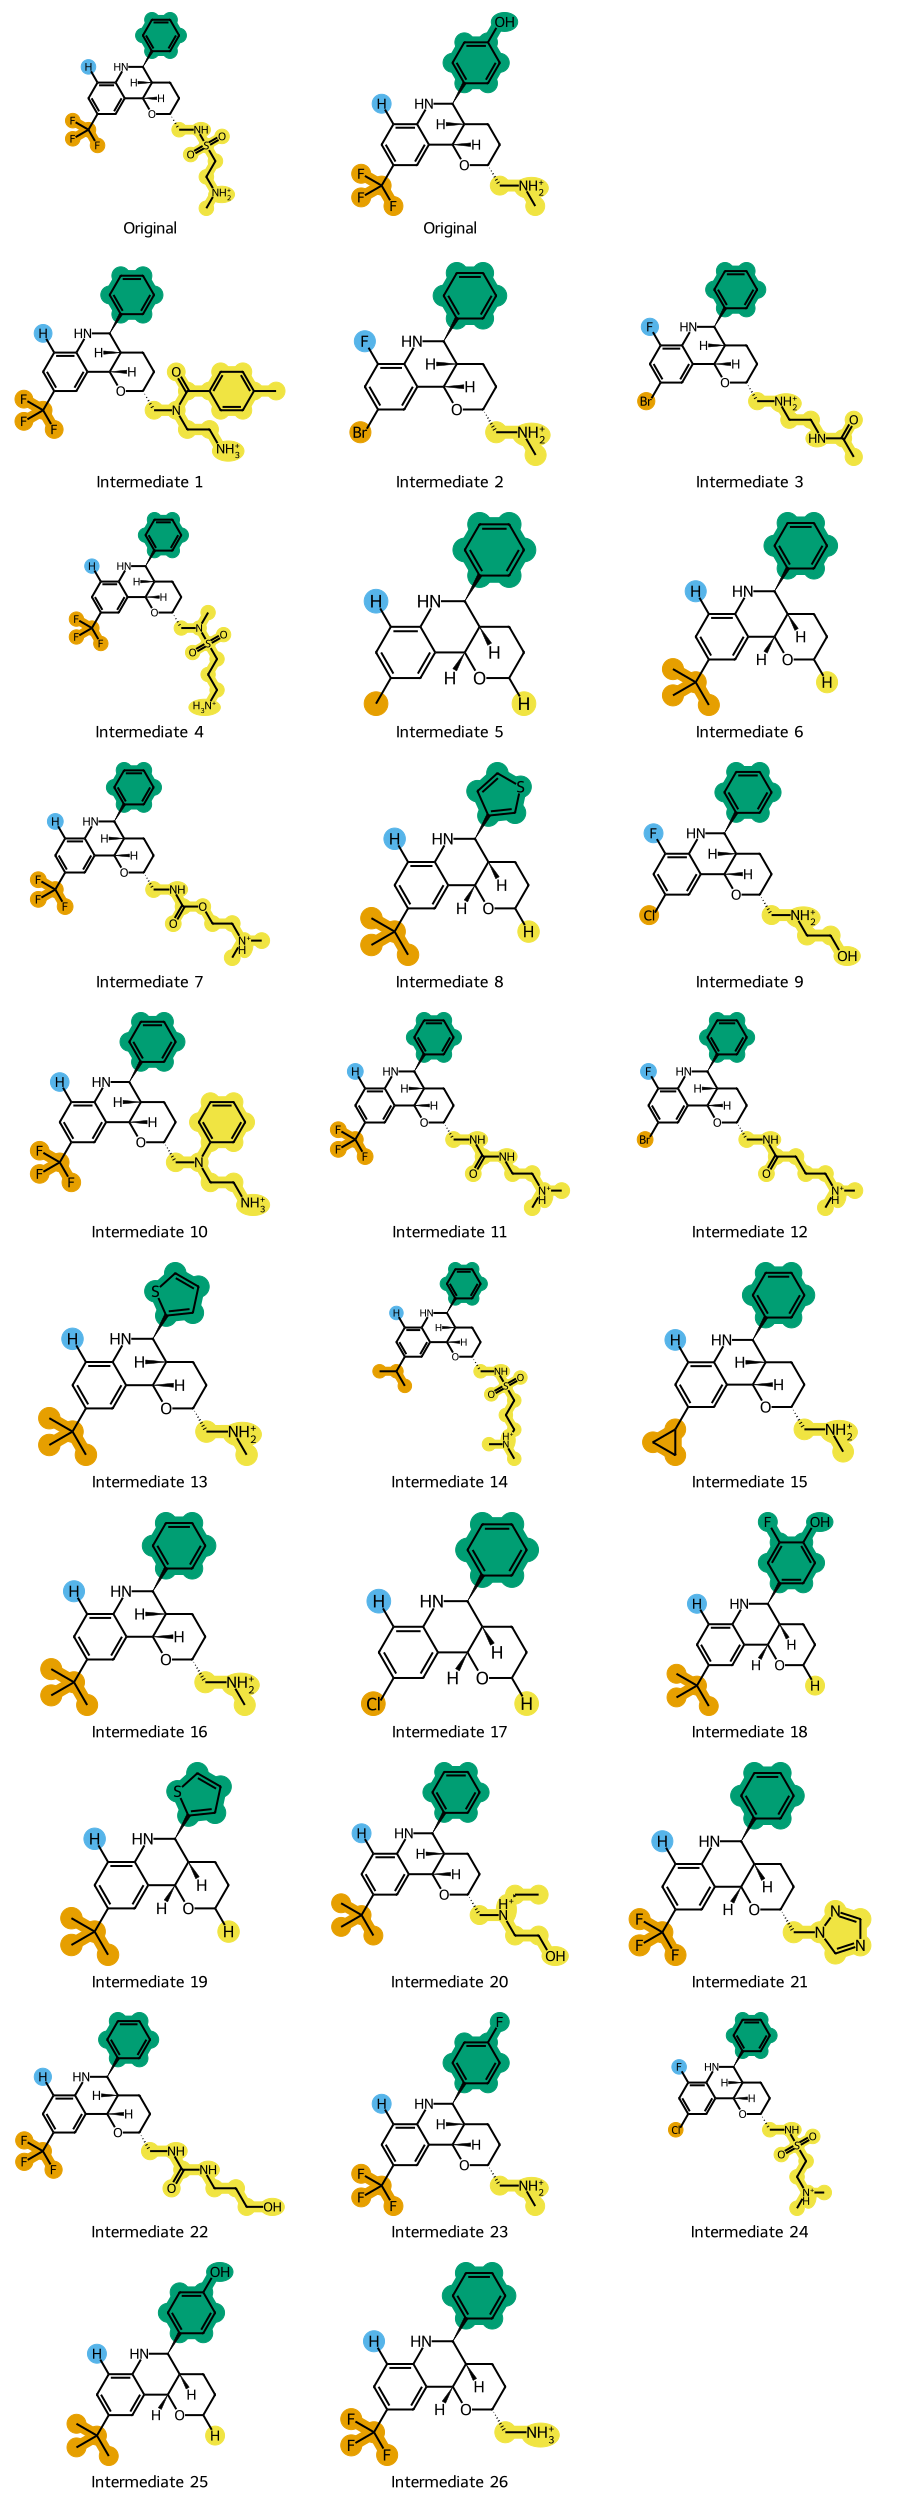

In [3]:
dir = 'eg5'
path = "fep_intermediate_generation/ligands/"
addendum = '*.sdf'
mols = []
for file in glob.glob(path + dir + '/' + addendum):
    mol = Chem.rdmolfiles.SDMolSupplier(file)[0]
    mols.append(mol)
print(f'The eg5 set has {len(mols)} unique molecules')
print(Chem.MolToSmiles(mols[1]))
core = Chem.MolFromSmiles('[C@@H]12CCCO[C@@H]1c3c(NC2)cccc3')
image = plot_highlighted(mols[0], mols[1], mols[2:], core)
image

## R-group enumeration
The figure above shows that there's 5 molecules for which all r-groups also occur in other molecules. Here we will remove those molecules from the set, creating a new set of seeding molecules. We will iterate over all the pairs in this set and create intermediates in a pairwise manner. For our 23 seeding molecules this means iterating over 252 pairs, which results in 1364 intermediates of which 544 are unique.

In [12]:
indexes = [7, 13, 22, 24, 25]
seeding_mols = [ele for i, ele in enumerate(mols) if i not in indexes]

df_comb = pd.DataFrame()
for i, (liga, ligb) in enumerate(combinations(seeding_mols, 2)):
    generator = EnumRGroups()
    liga = Chem.Mol(liga)
    ligb = Chem.Mol(ligb)
    df_interm, core = generator.generate_intermediates([liga, ligb])
    if 'Intermediate' in df_interm.keys():
        df_interm['Intermediate'] = df_interm['Intermediate'].apply(lambda x: Chem.MolToSmiles(x))
        df_interm['Pair'] = i
        df_interm['Parent_1'] = Chem.MolToSmiles(liga)
        df_interm['Parent_2'] = Chem.MolToSmiles(ligb)
        df_comb = pd.concat([df_comb, df_interm], ignore_index=True)

df_comb.to_csv('data/eg_5_intermediates.csv', index=False)

print(f'Number of pairs: {i}')
print(f'Number of intermediates: {len(df_comb)}')
print(f'Number of unique intermediates: {len(df_comb.Intermediate.unique())}')

Number of pairs: 252
Number of intermediates: 1364
Number of unique intermediates: 544


## Target molecules are regenerated
Next we will check whether the molecules we removed from the dataset (our target molecules) are created by the r-group enumeration, by comparing the intermediate SMILES to the target SMILES.

In [13]:
target_mols = [ele for i, ele in enumerate(mols) if i in indexes]
target_smiles = [Chem.MolToSmiles(x) for x in target_mols]
df_target = df_comb[df_comb['Intermediate'].isin(target_smiles)].reset_index(drop=True)
display(df_target)
print(
    f'Number of regererated target molecules: {len(df_target.Intermediate.unique())}'
)
print(target_smiles)

,Intermediate,SMILES,Pair,Parent_1,Parent_2
0,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,2,[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)(F)F)...,CC(C)(C)C1=CC=C2N[C@@H](C3=CC=C(O)C=C3)[C@@H]3...
1,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,7,[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)(F)F)...,CC(C)(C)C1=CC=C2N[C@@H](C3=CC=C(O)C(F)=C3)[C@@...
2,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,9,[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)(F)F)...,CC(C)(C)C1=CC=C2N[C@@H](C3=CC=CS3)[C@@H]3CCCO[...
3,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,14,[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)(F)F)...,CC(C)(C)C1=CC=C2N[C@@H](C3=CSC=C3)[C@@H]3CCCO[...
4,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,23,O=C(NCCCO)NC[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)...,CC(C)(C)C1=CC=C2N[C@@H](C3=CC=C(O)C=C3)[C@@H]3...
...,...,...,...,...,...
83,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,227,CC(C)(C)C1=CC=C2N[C@@H](C3=CSC=C3)[C@@H]3CCCO[...,CN(C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)(F)F)=CC...
84,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,228,CC(C)(C)C1=CC=C2N[C@@H](C3=CSC=C3)[C@@H]3CCCO[...,C[NH+](C)CCOC(=O)NC[C@H]1CC[C@@H]2[C@H](O1)C1=...
85,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,229,CC(C)(C)C1=CC=C2N[C@@H](C3=CSC=C3)[C@@H]3CCCO[...,CC(=O)NCC[NH2+]C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(...
86,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,230,CC(C)(C)C1=CC=C2N[C@@H](C3=CSC=C3)[C@@H]3CCCO[...,C[NH2+]CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)C1...


Number of regererated target molecules: 5
['C[NH2+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(C)(C)C)ccc1N[C@H]2c1ccccc1', 'C[NH2+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(C)(C)C)ccc1N[C@H]2c1cccs1', 'CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccccc1)N2', 'C[NH2+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(Br)cc(F)c1N[C@H]2c1ccccc1', 'C[NH2+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)ccc1N[C@H]2c1ccc(O)cc1']


## Pruning of generated intermediates
As R-group enumeration yields a lot of new intermediates with different degrees of usefulness for RFBE we have also created pruning mechanisms.

In [26]:
from rgroupinterm.pruners import BasePruner, TanimotoScorer, HarmonicMeanTransformer
import pandas as pd
from rdkit import Chem

df = pd.read_csv('data/eg_5_intermediates.csv')
df_mols = pd.DataFrame()
for column in ['Intermediate', 'Parent_1', 'Parent_2']:
    df_mols[column] = df[column].apply(lambda x: Chem.MolFromSmiles(x))
df_mols['Pair'] = df['Pair']

In [27]:
df_mols

,Intermediate,Parent_1,Parent_2,Pair
0,<rdkit.Chem.rdchem.Mol object at 0x7ff7259c7300>,<rdkit.Chem.rdchem.Mol object at 0x7ff7257fcdd0>,<rdkit.Chem.rdchem.Mol object at 0x7ff725822730>,2
1,<rdkit.Chem.rdchem.Mol object at 0x7ff7259c7370>,<rdkit.Chem.rdchem.Mol object at 0x7ff7257fcd60>,<rdkit.Chem.rdchem.Mol object at 0x7ff7258227a0>,2
2,<rdkit.Chem.rdchem.Mol object at 0x7ff7259c73e0>,<rdkit.Chem.rdchem.Mol object at 0x7ff7257fce40>,<rdkit.Chem.rdchem.Mol object at 0x7ff725822810>,2
3,<rdkit.Chem.rdchem.Mol object at 0x7ff7259c7450>,<rdkit.Chem.rdchem.Mol object at 0x7ff7257fceb0>,<rdkit.Chem.rdchem.Mol object at 0x7ff725822880>,2
4,<rdkit.Chem.rdchem.Mol object at 0x7ff7259c74c0>,<rdkit.Chem.rdchem.Mol object at 0x7ff7257fcf20>,<rdkit.Chem.rdchem.Mol object at 0x7ff7258228f0>,2
...,...,...,...,...
1359,<rdkit.Chem.rdchem.Mol object at 0x7ff7257fcb30>,<rdkit.Chem.rdchem.Mol object at 0x7ff725822500>,<rdkit.Chem.rdchem.Mol object at 0x7ff725847ed0>,251
1360,<rdkit.Chem.rdchem.Mol object at 0x7ff7257fcba0>,<rdkit.Chem.rdchem.Mol object at 0x7ff725822570>,<rdkit.Chem.rdchem.Mol object at 0x7ff725847f40>,251
1361,<rdkit.Chem.rdchem.Mol object at 0x7ff7257fcc10>,<rdkit.Chem.rdchem.Mol object at 0x7ff7258225e0>,<rdkit.Chem.rdchem.Mol object at 0x7ff725848040>,251
1362,<rdkit.Chem.rdchem.Mol object at 0x7ff7257fcc80>,<rdkit.Chem.rdchem.Mol object at 0x7ff725822650>,<rdkit.Chem.rdchem.Mol object at 0x7ff7258480b0>,251


In [15]:
pruner = BasePruner(
    [TanimotoScorer(transformer=HarmonicMeanTransformer(exponent=4))], topn=1)
pruned_df = pruner(df_mols)

In [16]:
for column in ['Intermediate', 'Parent_1', 'Parent_2']:
    pruned_df[column] = pruned_df[column].apply(lambda x: Chem.MolToSmiles(x))
df_target = pruned_df[pruned_df['Intermediate'].isin(
        target_smiles)].reset_index(drop=True)

In [17]:
print(
    f'Number of regererated target molecules: {len(df_target.Intermediate.unique())}'
)

Number of regererated target molecules: 2


# Plot similarity of intermediates to parents in context of parent similarity
Horizontal and vertical lines denote that intermediates are more similar to parent 1 than other parent was. Dashed diagonal is similarity of hypothetical intermediate that is exactly in between the two.

In [5]:
score_suffix='Lomap'

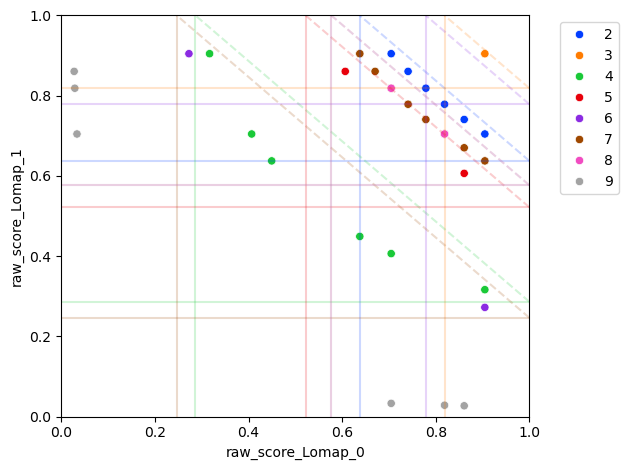

In [6]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

palette = sns.color_palette("bright")

path = 'data/eg5_scored.csv'
df = pd.read_csv(path)
df = df.loc[df['Pair']<10]

sns.scatterplot(data=df, x=f"raw_score_{score_suffix}_0", y=f"raw_score_{score_suffix}_1", hue="Pair", legend="full", palette='bright')

df_p = pd.read_csv('data/eg5_score_parents.csv')
for i, pair in enumerate(df.Pair.unique()):
    parent_score = df_p.loc[df_p['Pair'] ==
                            pair][f'Score_{score_suffix}'].values[0]
    plt.plot([1, parent_score], [parent_score, 1], color=palette[i], linestyle='dashed', alpha=0.2)
    plt.hlines(y=parent_score, xmin=0, xmax=1.0, color=palette[i], alpha=0.2)
    plt.vlines(x=parent_score, ymin=0, ymax=1.0, color=palette[i], alpha=0.2)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

# Plot example pairs

['[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)ccc1N[C@H]2c1ccccc1', 'O=C(NCCCO)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)ccc1N[C@H]2c1ccccc1', 'FC(F)(F)c1ccc2c(c1)[C@H]1O[C@@H](Cn3cncn3)CC[C@H]1[C@H](c1ccccc1)N2', 'CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc(O)cc1)N2', 'C[NH2+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)ccc1N[C@H]2c1ccc(F)cc1', 'C[NH+](C)CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(Cl)cc(F)c1N[C@H]2c1ccccc1', 'CC[N@H+](CCO)C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(C)(C)C)ccc1N[C@H]2c1ccccc1', 'C[NH2+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(C)(C)C)ccc1N[C@H]2c1ccccc1', 'C[NH2+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C3CC3)ccc1N[C@H]2c1ccccc1', 'CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc(O)c(F)c1)N2', 'Clc1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccccc1)N2']


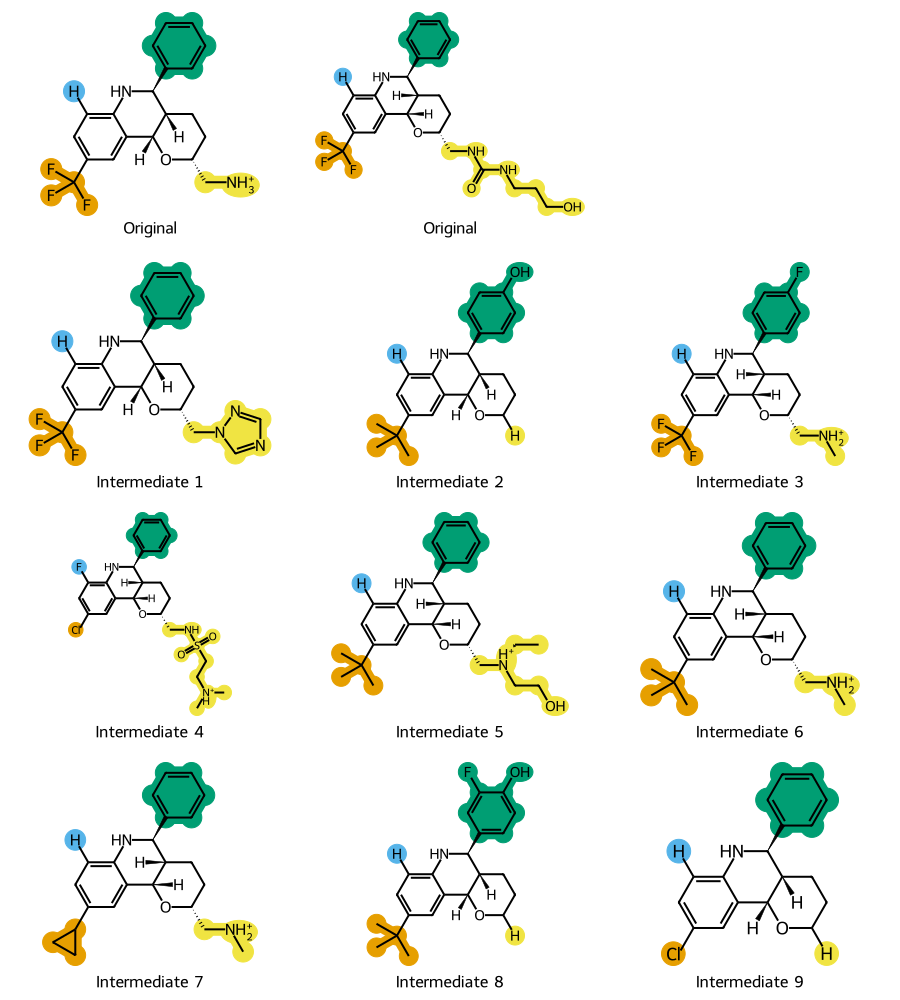

In [23]:
from rdkit import Chem
from rgroupinterm.rgroup_highlighting import plot_highlighted

df_p = pd.read_csv('data/eg5_score_parents.csv')
df_p = df_p.loc[df_p['Pair']<10]

core = Chem.MolFromSmiles('[C@@H]12CCCO[C@@H]1c3c(NC2)cccc3')
smiles = [df_p['Parent_1'][0]]
smiles.extend(df_p['Parent_2'].to_list())
print(smiles)
mols = [Chem.MolFromSmiles(x) for x in smiles]
image = plot_highlighted(mols[0], mols[1], mols[2:], core)
image

# Distribution of scores for enumerated original parent pairs

In [32]:
df = pd.read_csv('data/eg5_score_parents.csv')
df.hist('raw_score_Tanimoto_p')

KeyError: "None of [Index(['raw_score_Tanimoto_p'], dtype='object')] are in the [columns]"

In [14]:
df_p = pd.read_csv('data/eg5_score_parents.csv')
df_p[['raw_score_Tanimoto_p',
       'raw_score_Lomap_p', 'raw_score_ROCS_p']].mean()

raw_score_Tanimoto_p    0.365994
raw_score_Lomap_p       0.264118
raw_score_ROCS_p        0.663826
dtype: float64

# Plot molecules with the score compared to both parents
Harmonic mean. Can do of any pair & score, results are shown for most and least similar original pairs.

In [33]:
def harmonic_mean(scores):
    score = 2 * (scores[0] * scores[1]) / (
            scores[0] + scores[1])
    return score

In [34]:
from rdkit import Chem
import pandas as pd
from rgroupinterm.rgroup_highlighting import plot_highlighted

df_p = pd.read_csv('data/eg5_score_parents.csv')

score = 'Tanimoto'
pair = 115 #115, 116, 105, 11, 94, 14

# df_max = df_p.iloc[df_p[f'Score_{score}'].idxmax()]
df_max = df_p.loc[df_p['Pair'] == pair]
scores = [df_max[f'Score_{score}'][pair]] * 2

path = 'data/eg5_scored.csv'
df = pd.read_csv(path)
df = df.loc[df['Pair'] == pair].reset_index()
res = [harmonic_mean([i, j]) for i, j in zip(df[f'raw_score_{score}_0'].to_list(), df[f'raw_score_{score}_1'].to_list())]

scores.extend(res)

core = Chem.MolFromSmiles('[C@@H]12CCCO[C@@H]1c3c(NC2)cccc3')
smiles = [df['Parent_1'][0]]
smiles.append(df['Parent_2'][0])
smiles.extend(df['Intermediate'].to_list())
print(smiles)
mols = [Chem.MolFromSmiles(x) for x in smiles]
image = plot_highlighted(mols[0], mols[1], mols[2:], core, scores)

['C[NH+](C)CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)C1=CC(Cl)=CC(F)=C1N[C@H]2C1=CC=CC=C1', 'C[NH2+]CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)(F)F)=CC=C1N[C@H]2C1=CC=CC=C1', 'C[NH2+]CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(Cl)cc(F)c1N[C@H]2c1ccccc1', 'C[NH+](C)CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(Cl)ccc1N[C@H]2c1ccccc1', 'C[NH2+]CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(Cl)ccc1N[C@H]2c1ccccc1', 'C[NH+](C)CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)cc(F)c1N[C@H]2c1ccccc1', 'C[NH2+]CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)cc(F)c1N[C@H]2c1ccccc1', 'C[NH+](C)CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)ccc1N[C@H]2c1ccccc1']


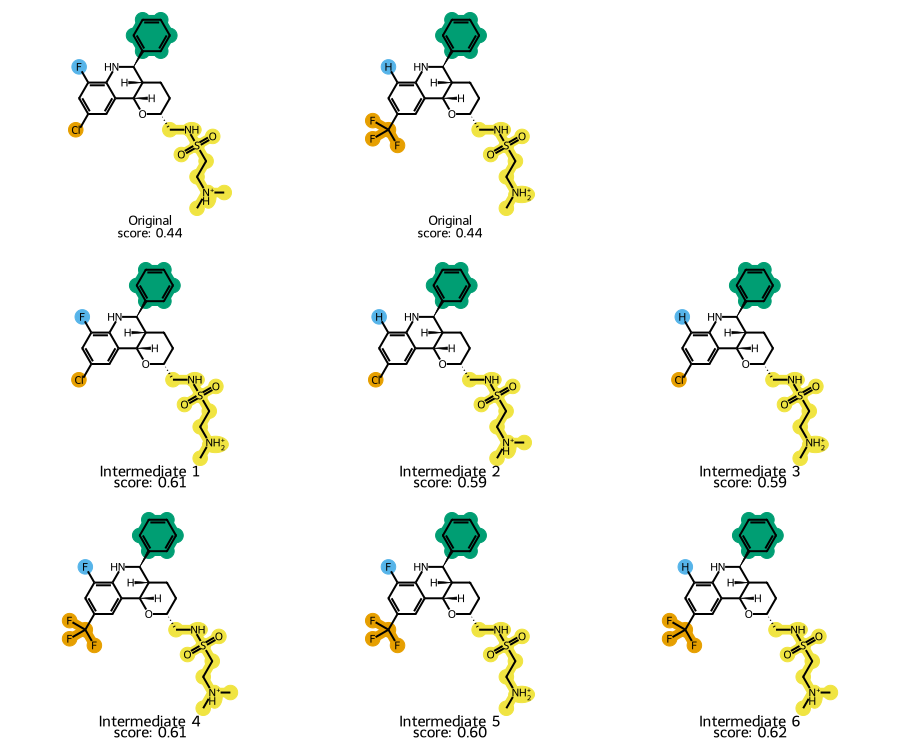

In [35]:
image

In [36]:
df_min = df_p.iloc[df_p[f'raw_score_{score}_p'].idxmin()]
scores = [df_min[f'raw_score_{score}_p']] * 2

path = 'data/eg5_scored.csv'
df = pd.read_csv(path)
df = df.loc[df['Pair'] == df_p.iloc[df_p[f'raw_score_{score}_p'].idxmin()].Pair].reset_index()
res = [harmonic_mean([i, j]) for i, j in zip(df[f'raw_score_{score}_0'].to_list(), df[f'raw_score_{score}_1'].to_list())]
scores.extend(res)

core = Chem.MolFromSmiles('[C@@H]12CCCO[C@@H]1c3c(NC2)cccc3')
smiles = [df['Parent_1'][0]]
smiles.append(df['Parent_2'][0])
smiles.extend(df['Intermediate'].to_list())
print(smiles)
mols = [Chem.MolFromSmiles(x) for x in smiles]
image = plot_highlighted(mols[0], mols[1], mols[2:], core, scores)

KeyError: 'raw_score_Tanimoto_p'

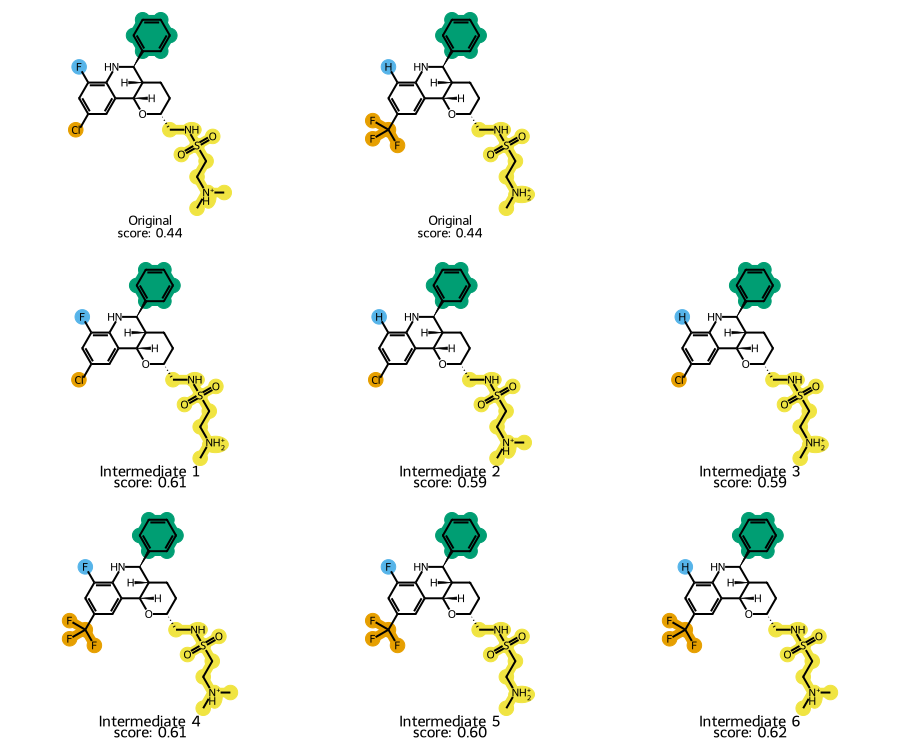

In [37]:
image